In this notebook, you will use SVM (Support Vector Machines) to build and train a model using human cell records, and classify cells to whether the samples are benign or malignant.

SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data is transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong.

In [ ]:
! pip install scikit-learn==0.23.1

In [ ]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

'all done'

'all done'

In [ ]:
!wget -O cell_samples.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/cell_samples.csv




--2022-05-08 03:29:29--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/cell_samples.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19975 (20K) [text/csv]
Saving to: ‘cell_samples.csv’

cell_samples.csv    100%[===================>]  19.51K  --.-KB/s    in 0s      

2022-05-08 03:29:30 (203 MB/s) - ‘cell_samples.csv’ saved [19975/19975]



In [ ]:
cell_df = pd.read_csv('cell_samples.csv')

cell_df.head(10)

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2


The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

Let's look at the distribution of the classes based on Clump thickness and Uniformity of cell size:/

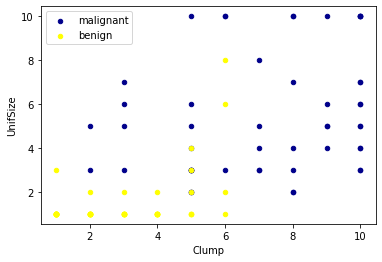

In [ ]:
ax = cell_df[cell_df['Class'] == 4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant');
cell_df[cell_df['Class'] == 2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='benign', ax=ax);
plt.show()

In [ ]:
## Data Preparation

cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

In [ ]:
cell_df.shape

(699, 11)

In [ ]:
cell_df.describe(include='all')

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699,699.000000,699.000000,699.000000,699.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,11,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,402,NaN,NaN,NaN,NaN
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,NaN,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,NaN,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,NaN,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,NaN,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,NaN,5.000000,4.000000,1.000000,4.000000


In [ ]:
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()] ##changing to NAN and then deleting it
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int64
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [ ]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]])

In [ ]:
cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])
y [0:20]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array([2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 4, 4, 2, 2, 4, 2])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=None)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as: (can use same set of codes for each kernel)

```
1.Linear
2.Polynomial
3.Radial basis function (RBF)
4.Sigmoid
```

Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset. We usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for this lab.

In [ ]:
from sklearn import svm
clf = svm.SVC(kernel= 'linear')
clf.fit(X_train,y_train)

yhat = clf.predict(X_test)
yhat [0:10]

array([2, 2, 4, 2, 2, 4, 4, 4, 2, 4])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       0.97      1.00      0.98        90
           4       1.00      0.94      0.97        47

    accuracy                           0.98       137
   macro avg       0.98      0.97      0.98       137
weighted avg       0.98      0.98      0.98       137

Confusion matrix, without normalization
[[90  0]
 [ 3 44]]


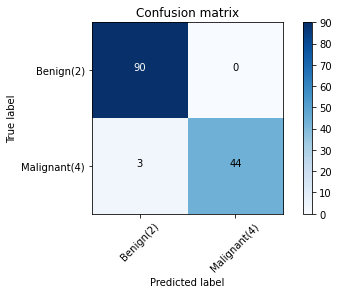

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted')

0.977920727113021

In [ ]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat,pos_label=2)

0.967741935483871

In [ ]:
#comparing accuracy
clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train) 
yhat2 = clf2.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, yhat2, average='weighted'))
print("Jaccard score: %.4f" % jaccard_score(y_test, yhat2,pos_label=2))

Avg F1-score: 0.9779
Jaccard score: 0.9677
